In [ ]:
#@title Install dependencies. { display-mode: "form" }
!pip3 install torch torchvision torchaudio transformers sentencepiece accelerate --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
#@title Import dependencies. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50)
from transformers import T5Tokenizer, T5EncoderModel
import torch
import re
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModel, AutoTokenizer
from sklearn.manifold import TSNE
from google.colab import drive
import torch, os, polars as pl, pandas as pd, random, matplotlib.pyplot as plt, numpy as np, shutil
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import time, random
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cuda:0


In [ ]:
#@title Mount drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc_project/all_paired'
os.chdir(path)
os.listdir()

In [ ]:
df = pd.read_csv('230625_human_paired_seqs.csv', engine='pyarrow', dtype={'Run':np.str_})

In [ ]:
linker = 'SGGSTITSYNVYYTKLSSSGT'

df['scfv'] = df['sequence_alignment_aa_light'] + [linker]*df.shape[0] + df['sequence_alignment_aa_heavy']

df.to_csv('230716_human_paired_seqs.csv', index=False)

In [ ]:
df = pd.read_csv('230716_human_paired_seqs.csv', engine='pyarrow', dtype={'Run':np.str_})

In [ ]:
#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50 in half-precision)
transformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link)
model.full() if device=='cpu' else model.half() # only cast to full-precision if no GPU is available
model = model.to(device)
model = model.eval()
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False )

The code below creates a function that will take a list of sequences, and return embeddings for those sequences using the protT5 encoder.

I then set up a simple for loop to loop through a dataframe and generate embeddings for a subset (k = 100) and then convert them to a numpy array. The array is then saved to a list.

The sequences have to processed in these batches since the GPU RAM is not sufficient to handle >100 tensors at a time.

In [ ]:
l = random.choices([i for i in range(df.shape[0])], k=10000)

df1 = df.copy().iloc[l]

def process_seqs(seqs: list) -> list:
  # this will replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
  seqs = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in seqs]
  # tokenize sequences and pad up to the longest sequence in the batch
  ids = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
  input_ids = torch.tensor(ids['input_ids']).to(device)
  attention_mask = torch.tensor(ids['attention_mask']).to(device)
  # generate embeddings
  with torch.no_grad():
      embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)
  ember = embedding_repr.last_hidden_state
  #derivation of per-protein embedding for all embedded proteins
  ember = [i.mean(dim=0) for i in ember]
  return ember

l = []
batch_size = 100
for i in range(0, df1.shape[0], batch_size):
    df2 = df1.iloc[i:i + batch_size]
    batch = df2['scfv'].to_list()
    batch = process_seqs(batch)
    # Convert protein_embeddings to a numpy array
    protein_embeddings_np = np.array([emb.cpu().numpy() for emb in batch])
    # Save protein_embeddings to a Parquet file
    df_tensor = pd.DataFrame(protein_embeddings_np)
    df_tensor['seq'] = df2['seq_id'].to_list()
    l.append(df_tensor)

In [ ]:
tensor_df = pd.concat(l)
tensor_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,seq
0,-0.002308,0.107300,0.019150,-0.000226,-0.023254,0.037476,-0.015068,-0.086609,0.022736,-0.050140,...,0.015076,-0.079956,-0.065186,-0.018311,-0.034882,0.028824,0.057770,-0.014717,0.002920,AGACGTTCAAGGACTG-1_contig_1_AGACGTTCAAGGACTG-1...
1,-0.002766,0.098633,0.016571,0.003231,-0.017853,0.031525,-0.039490,-0.102356,0.008224,-0.023346,...,0.045837,-0.057007,-0.074402,0.030731,-0.000563,0.016708,0.045105,-0.001222,-0.022156,CTCGGGATCAACGGGA-1_contig_1_CTCGGGATCAACGGGA-1...
2,-0.002945,0.077820,0.019760,0.011436,-0.031921,0.038818,-0.035461,-0.079285,0.015808,-0.043884,...,0.034210,-0.074524,-0.063965,0.007282,-0.011749,0.021622,0.057800,-0.001407,-0.010262,ACATGGTCAGATAATG-1_contig_1_ACATGGTCAGATAATG-1...
3,0.010284,0.114075,0.028564,0.002213,-0.013191,0.037476,-0.026520,-0.086182,0.009140,-0.038879,...,0.032837,-0.063721,-0.072083,-0.009033,-0.019241,0.025421,0.046021,-0.008942,-0.004612,CGGAGTCCATATGAGA-1_contig_2_CGGAGTCCATATGAGA-1...
4,0.000618,0.101746,0.020752,-0.006859,-0.016602,0.047455,-0.030838,-0.091431,0.015038,-0.033325,...,0.031097,-0.072693,-0.062683,-0.023071,-0.018341,0.030624,0.049103,0.000762,-0.002625,GGAACTTAGCCAGAAC-1_contig_2_GGAACTTAGCCAGAAC-1...


In [ ]:
tensor_df.shape

(10000, 1025)

In [ ]:
tensor_df.to_csv('230716_scfv_10000.csv', index=False) #need to change this to contain ProtT5 in the name, to distinguish from other pLMs used

The text below runs through the flow of generating embeddings for just one batch, rather than looping through 10000.

In [ ]:
l = random.choices([i for i in range(df.shape[0])], k=100)

df = df.iloc[l]

In [ ]:
seq1 = df['sequence_alignment_aa_light'].to_list()
seqs = df['scfv'].to_list()

In [ ]:
# this will replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
seqs = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in seqs]

# tokenize sequences and pad up to the longest sequence in the batch
ids = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

In [ ]:
# generate embeddings
with torch.no_grad():
    embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)

emb_0 = embedding_repr.last_hidden_state

#derivation of per-protein embedding for all embedded proteins
emb_proteins = [i.mean(dim=0) for i in emb_0]
len(emb_proteins)

100

In [ ]:
emb_proteins[0]

tensor([ 0.0018,  0.1237,  0.0071,  ...,  0.0171, -0.0157, -0.0054],
       device='cuda:0', dtype=torch.float16)

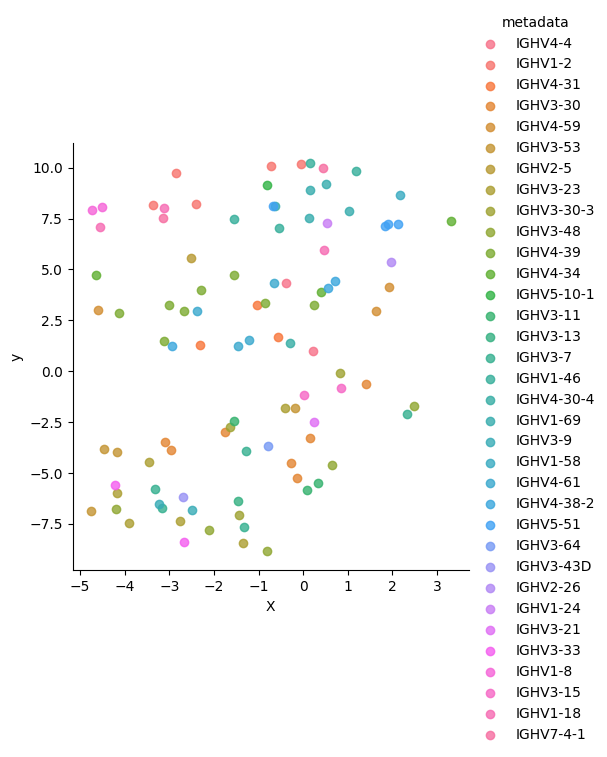

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
protein_tsne = tsne.fit_transform(torch.stack(emb_proteins).cpu().numpy())

X=protein_tsne[:, 0]
y=protein_tsne[:, 1]
metadata = df['v_call_heavy']

new_df = pd.DataFrame([X, y, metadata]).transpose()

new_df.rename(columns={0:'X', 1:'y', 2:'metadata'}, inplace=True)

new_df['metadata'] = new_df['metadata'].apply(lambda x: x.split('*')[0])
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='X', y='y', data=new_df, fit_reg=False, hue='metadata', legend=True)

plt.show()

In [ ]:
new_df.to_parquet('230701_dim_reduced_TSNE_rand1000.parquet')

In [ ]:
# Convert protein_embeddings to a numpy array
protein_embeddings_np = np.array([emb.cpu().numpy() for emb in emb_proteins])

# Save protein_embeddings to a Parquet file

df_tensor = pd.DataFrame(protein_embeddings_np)
df_tensor['seq'] = df['seq_id'].to_list()


TSNE

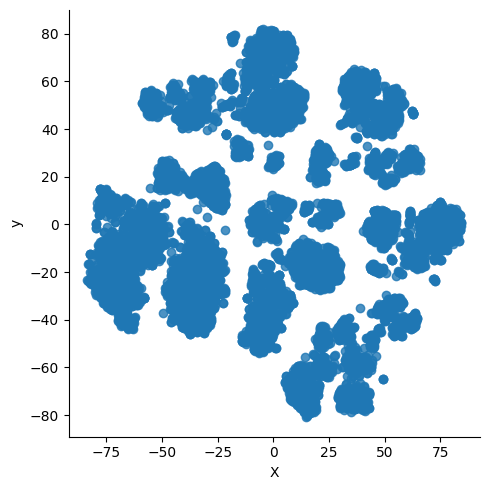

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
protein_tsne = tsne.fit_transform(tensor_df.iloc[:,:-1])

X=protein_tsne[:, 0]
y=protein_tsne[:, 1]
# metadata = df1['v_call_heavy']

new_df = pd.DataFrame([X, y]).transpose()

new_df.rename(columns={0:'X', 1:'y'}, inplace=True)

#new_df['metadata'] = new_df['metadata'].apply(lambda x: x.split('*')[0])
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='X', y='y', data=new_df, fit_reg=False, legend=True)

plt.show()

UMAP

In [ ]:
!conda install -c conda-forge umap-learn

/bin/bash: line 1: conda: command not found


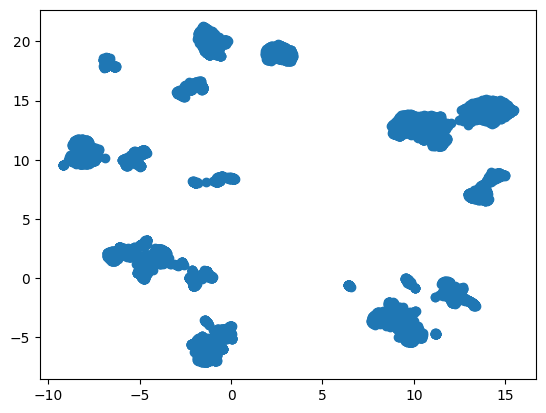

In [ ]:
import umap.umap_ as umap

umap_embedding = umap.UMAP(n_components=2, random_state=42)
protein_umap = umap_embedding.fit_transform(tensor_df.iloc[:,:-1])
X = protein_umap[:, 0]
y = protein_umap[:, 1]

new_df = pd.DataFrame({'X': X, 'y': y})

plt.scatter(new_df['X'], new_df['y'])

plt.show()

PCA

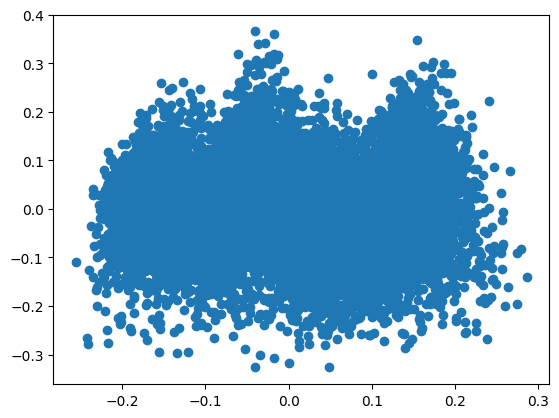

In [ ]:
from sklearn.decomposition import PCA
pca_2 = PCA(n_components=2, random_state=42)
pca_2_result = pca_2.fit_transform(tensor_df.iloc[:,:-1])
X = pca_2_result[:, 0]
y = pca_2_result[:, 1]

new_df = pd.DataFrame({'X': X, 'y': y})

plt.scatter(new_df['X'], new_df['y'])

plt.show()